# データの前処理

ヘッダーや日本語カラムの処理、不要カラムの削除など

実行前に`gdp.csv`や`temp.csv`は`INPUT_DIR`の示すフォルダに保存しておく必要がある。

# 電力データ

In [1]:
import requests
import io
import datetime

import pandas as pd
import matplotlib.pylab as plt

In [2]:
# https://www.tepco.co.jp/forecast/html/download-j.html
# https://www.tepco.co.jp/forecast/html/images/juyo-{year}.csv

YEARS = [2016, 2017, 2018, 2019, 2020, 2021]

# Colabではコメントアウトを外す。

# from google.colab import drive
# drive.mount('/content/drive')

# GOOGLE_MY_DRIVE = "/content/drive/MyDrive/code/input/"


INPUT_DIR = "input/"

# INPUT_DIR = GOOGLE_MY_DRIVE

In [3]:
df_list = [pd.read_csv(INPUT_DIR + f"juyo-{y}.csv") for y in YEARS]
df = pd.concat(df_list)

In [4]:
df.describe()

,実績(万kW)
count,43632.000000
mean,3249.712321
std,651.745081
min,1877.000000
25%,2734.000000
50%,3204.000000
75%,3670.000000
max,5653.000000


In [5]:
# Null(欠損値)は無い
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43632 entries, 0 to 1967
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   DATE     43632 non-null  object
 1   TIME     43632 non-null  object
 2   実績(万kW)  43632 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.3+ MB


In [6]:
df["datetime"] = pd.to_datetime(df["DATE"] + " " + df["TIME"]) # Datetime型にしておくと処理が楽
df['date'] = pd.to_datetime(df['DATE'])
df["power"] = df["実績(万kW)"] / 100  # GW unit, カラム名は英語にする
df = df.set_index("datetime")

In [7]:
#同じ日付のデータ（時刻が異なる）で集めて平均・標準偏差を取る
se_day = df.groupby('date').mean()['power']
df_day = pd.DataFrame(se_day)
df_day['power_std'] = df.groupby('date').std()['power'] 
df_day.head()

,power,power_std
date,,
2016-04-01,29.844167,3.890796
2016-04-02,29.074167,3.279035
2016-04-03,26.582500,2.745138
2016-04-04,29.562083,4.809870
2016-04-05,31.905000,5.068970


In [8]:
# 週単位で平均・標準偏差を算出。時刻単位のデータではなく、日付単位のデータで集計する。平均気温などの算出方法に倣う。
df_week_temp = df_day.copy().reset_index(drop=False)
df_week_temp['year'] = df_week_temp['date'].dt.isocalendar().year
df_week_temp['week'] = df_week_temp['date'].dt.isocalendar().week #週番号（1~53）の取得

grp = df_week_temp.groupby(['year', 'week'])

se_week = grp.mean()['power']
df_week = pd.DataFrame(se_week)
df_week['power_std'] = grp.std()['power']
df_week['date'] = grp.min()['date'] # 週の最初の日をインデックスにする。
df_week = df_week.set_index('date')
df_week = df_week.drop(df_week.index[[0, -1]]) #半端な週を除く
df_week.head()

,power,power_std
date,,
2016-04-04,29.249286,2.442016
2016-04-11,29.392024,2.068137
2016-04-18,28.636488,1.573074
2016-04-25,28.005298,2.433128
2016-05-02,25.686905,1.276991


In [9]:
# 月の集計。こちらも日付単位から集計する。
df_month_temp = df_day.copy().reset_index(drop=False)
df_month_temp['year'] = df_month_temp['date'].dt.year
df_month_temp['month'] = df_month_temp['date'].dt.month #月の取得

grp = df_month_temp.groupby(['year', 'month'])

se_month = grp.mean()['power']
df_month = pd.DataFrame(se_month)
df_month['power_std'] = grp.std()['power']
df_month['date'] = grp.min()['date'] # 最初の日をインデックスにする。
df_month = df_month.set_index('date')
df_month.head()

,power,power_std
date,,
2016-04-01,28.939944,1.906330
2016-05-01,28.385927,2.510186
2016-06-01,30.217639,1.957951
2016-07-01,33.144852,2.865702
2016-08-01,34.949583,3.306579


In [10]:
# 年単位の集計。こちらは月単位のデータから集計する。
df_year_temp = df_month.copy().reset_index(drop=False)
df_year_temp['year'] = df_year_temp['date'].dt.year

grp = df_year_temp.groupby(['year'])

se_year = grp.mean()['power']
df_year = pd.DataFrame(se_year)
df_year['power_std'] = grp.std()['power']
df_year['date'] = grp.min()['date'] # 最初の日をインデックスにする。
df_year = df_year.set_index('date')
df_year = df_year.drop(df_year.index[[0, -1]]) #半端な年を除く
df_year.head()

,power,power_std
date,,
2017-01-01,32.661112,2.909179
2018-01-01,33.247894,3.835275
2019-01-01,32.580764,3.130210
2020-01-01,31.735284,3.568286


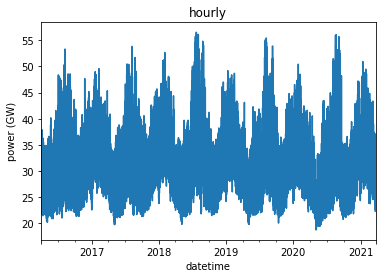

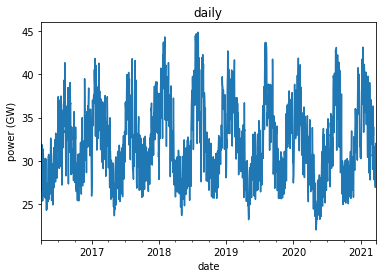

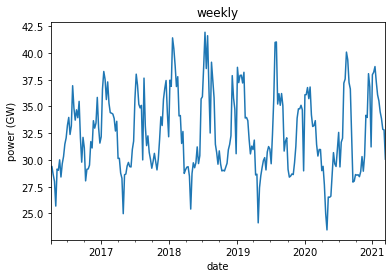

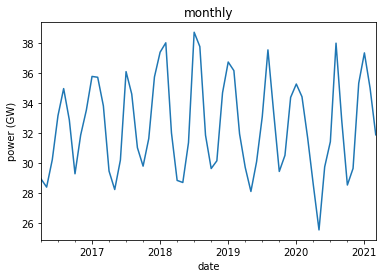

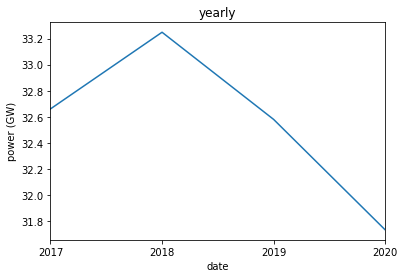

In [11]:
dfs = [df, df_day, df_week, df_month, df_year]
comments = ['hourly', 'daily', 'weekly', 'monthly', 'yearly']

for c, d in zip(comments, dfs):
    plt.title(f'{c}')
    d['power'].plot()
    plt.ylabel('power (GW)')
    plt.show()

In [12]:
df[['power']].to_csv(INPUT_DIR + 'hourly.csv', index=True)
df_day.to_csv(INPUT_DIR + 'daily.csv', index=True)
df_week.to_csv(INPUT_DIR + 'weekly.csv', index=True)
df_month.to_csv(INPUT_DIR + 'monthly.csv', index=True)
df_year.to_csv(INPUT_DIR + 'yearly.csv', index=True)

In [13]:
df_day = pd.read_csv(INPUT_DIR + 'daily.csv')
df_day['date'] = pd.to_datetime(df_day['date'])
df_day = df_day.set_index('date')

df_week = pd.read_csv(INPUT_DIR + 'weekly.csv')
df_week['date'] = pd.to_datetime(df_week['date'])
df_week = df_week.set_index('date')

df_month = pd.read_csv(INPUT_DIR + 'monthly.csv')
df_month['date'] = pd.to_datetime(df_month['date'])
df_month = df_month.set_index('date')

df_year = pd.read_csv(INPUT_DIR + 'yearly.csv')
df_year['date'] = pd.to_datetime(df_year['date'])
df_year = df_year.set_index('date')

# 気温データ

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# ref: https://www.data.jma.go.jp/gmd/risk/obsdl/index.php

df = pd.read_csv(INPUT_DIR + 'temp.csv', header=3, encoding="shift-jis")
df = df.rename(columns={"Unnamed: 0":"date", "Unnamed: 1":"temperature"})
df.head()

,date,temperature,品質情報,均質番号
0,2016/4/1,12.8,8,1
1,2016/4/2,10.5,8,1
2,2016/4/3,13.1,8,1
3,2016/4/4,15.6,8,1
4,2016/4/5,10.8,8,1


In [4]:
#欠損無し
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1796 entries, 0 to 1795
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         1796 non-null   object 
 1   temperature  1796 non-null   float64
 2   品質情報         1796 non-null   int64  
 3   均質番号         1796 non-null   int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 56.2+ KB


In [5]:
df.describe()

,temperature,品質情報,均質番号
count,1796.000000,1796.000000,1796.0
mean,16.565535,7.994989,1.0
std,7.868848,0.122542,0.0
min,0.000000,5.000000,1.0
25%,9.300000,8.000000,1.0
50%,16.850000,8.000000,1.0
75%,23.025000,8.000000,1.0
max,32.200000,8.000000,1.0


In [6]:
df = df.drop(df.columns[[2,3]], axis=1) # 品質情報や均質番号は一旦無視
df['date'] = pd.to_datetime(df['date'])

Text(0, 0.5, 'degC')

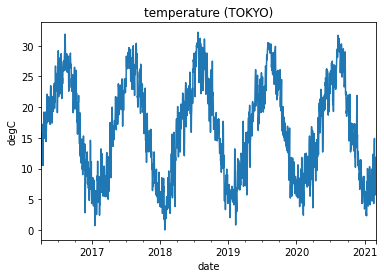

In [7]:
plt.title('temperature (TOKYO)')
df.set_index('date')['temperature'].plot()
plt.ylabel('degC')

In [8]:
df_week_temp = df.copy().reset_index(drop=False)
df_week_temp['year'] = df_week_temp['date'].dt.isocalendar().year
df_week_temp['week'] = df_week_temp['date'].dt.isocalendar().week #週番号（1~53）の取得

grp = df_week_temp.groupby(['year', 'week'])

se_week = grp.mean()['temperature']
df_week = pd.DataFrame(se_week)
df_week['temperature_std'] = grp.std()['temperature']
df_week['date'] = grp.min()['date'] # 週の最初の日をインデックスにする。
df_week = df_week.set_index('date')
df_week = df_week.drop(df_week.index[[0, -1]]) #半端な週を除く
df_week.head()

,temperature,temperature_std
date,,
2016-04-04,15.028571,2.238090
2016-04-11,14.685714,2.928269
2016-04-18,16.771429,1.362246
2016-04-25,17.114286,1.722816
2016-05-02,20.371429,1.893598


In [9]:
df_month_temp = df.copy().reset_index(drop=False)
df_month_temp['year'] = df_month_temp['date'].dt.year
df_month_temp['month'] = df_month_temp['date'].dt.month #月の取得

grp = df_month_temp.groupby(['year', 'month'])

se_month = grp.mean()['temperature']
df_month = pd.DataFrame(se_month)
df_month['temperature_std'] = grp.std()['temperature']
df_month['date'] = grp.min()['date'] # 最初の日をインデックスにする。
df_month = df_month.set_index('date')
df_month.head()

,temperature,temperature_std
date,,
2016-04-01,15.446667,2.469641
2016-05-01,20.161290,1.905374
2016-06-01,22.353333,2.003399
2016-07-01,25.374194,2.224555
2016-08-01,27.116129,1.703153


In [10]:
df_year_temp = df_month.copy().reset_index(drop=False)
df_year_temp['year'] = df_year_temp['date'].dt.year

grp = df_year_temp.groupby(['year'])

se_year = grp.mean()['temperature']
df_year = pd.DataFrame(se_year)
df_year['temperature_std'] = grp.std()['temperature']
df_year['date'] = grp.min()['date'] # 最初の日をインデックスにする。
df_year = df_year.set_index('date')
df_year = df_year.drop(df_year.index[[0, -1]]) #半端な年を除く
df_year.head()

,temperature,temperature_std
date,,
2017-01-01,15.825266,7.886118
2018-01-01,16.770907,8.129271
2019-01-01,16.440164,7.661283
2020-01-01,16.529431,7.504154


In [11]:
df.to_csv(INPUT_DIR + 'daily_temperature.csv', index=True)
df_week.to_csv(INPUT_DIR + 'weekly_temperature.csv', index=True)
df_month.to_csv(INPUT_DIR + 'monthly_temperature.csv', index=True)
df_year.to_csv(INPUT_DIR + 'yearly_temperature.csv', index=True)

# GDPデータ

In [1]:
import re
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# https://www.esri.cao.go.jp/jp/sna/data/data_list/sokuhou/files/files_sokuhou.html

df = pd.read_csv(INPUT_DIR + 'gdp.csv', header=5, encoding="shift-jis")
df = df[['Unnamed: 0', 'GDP(Expenditure Approach)']]\
        .rename(columns={'Unnamed: 0':'quater', 'GDP(Expenditure Approach)':'gdp'})\
        .drop(df.index[[0, -1]])
df.head()

,quater,gdp
1,1994/ 1- 3.,"123,456.1"
2,4- 6.,"124,896.6"
3,7- 9.,"125,738.4"
4,10-12.,"136,825.0"
5,1995/ 1- 3.,"124,494.6"


In [4]:
def convert_figure(string):
    '''
    文字列から小数に変換する
    '''
    pattern = "\,| " #桁区切りのカンマ及び空白の除去
    result = re.sub(pattern, '', string)
    
    pattern = "\." #小数点
    result = re.sub(pattern, '.', result)
    return float(result)

In [5]:
df.index = pd.date_range('1994-01-01', '2020-12-31', freq="QS", name='date')
df['gdp'] = df['gdp'].apply(convert_figure) / 100000 # 100兆円単位にする。
df = df.reset_index(drop=False)

In [6]:
# 日次テーブルにする。テーブルの結合のため同一四半期内では同じGDPが入る。
df_daily = pd.DataFrame(index=pd.date_range('2016-04-01', '2020-12-31', name='date')).reset_index(drop=False)
df_daily = pd.merge(df_daily, df[['date', 'gdp']], on='date', how='left').ffill()
df_daily.to_csv(INPUT_DIR + 'daily_gdp.csv', index=True)

Text(0, 0.5, 'GDP (100,000,000,000 JPY)')

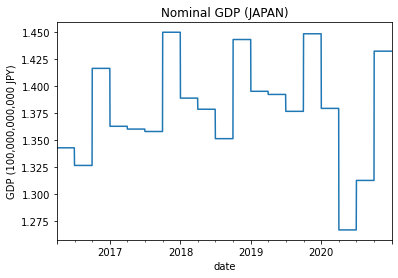

In [7]:
plt.title('Nominal GDP (JAPAN)')
df_daily.set_index('date')['gdp'].plot()
plt.ylabel('GDP (100,000,000,000 JPY)')

In [8]:
df_weekly = df_daily[df_daily['date'].dt.dayofweek == 0]
df_weekly.to_csv(INPUT_DIR + 'weekly_gdp.csv', index=True)

<AxesSubplot:xlabel='date'>

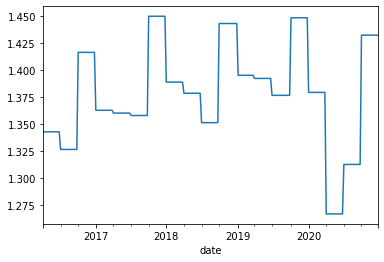

In [9]:
df_weekly.set_index('date')['gdp'].plot()

In [10]:
df_daily.head()

,date,gdp
0,2016-04-01,1.342716
1,2016-04-02,1.342716
2,2016-04-03,1.342716
3,2016-04-04,1.342716
4,2016-04-05,1.342716
